# Step-by-step tutorial for functions in `simsz`

Eve Vavagiakis et al., Last edited date

explore some basic functionality of the simsz fastsim code from DeepSkies

## Imports

In [2]:
import simsz.make_sz_cluster as make_sz_cluster
import simsz.dm_halo_dist as dm_halo_dist
import simsz.utils as utils
from simsz import simtools, noise, filters, visualization
import simsz.load_vars as load_vars
from colossus.halo import mass_adv

import time
from datetime import datetime as dt
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

Next, we load create a dictionary from the variables `input.yaml`. We then load in the keys from the dictionary to create our variables. 

In [3]:
d=load_vars.load_vars().make_dict_and_flatLCDM() #Make a dictionary and cosmology from the .yaml
d.keys()
d['cosmo']

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.25, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.043)

Next, we create a new flat redshift and virial mass distribution using the function `flastdist_halo` from `dm_halo_dist` which uses random uniform generation. Our distribution saved to a h5 file titled `massdist.h5`. You can find this file in the outfiles folder. Below are three graphs, showing the redshift distribution, virial mass distribution, and redshift and virial mass scatterplot.

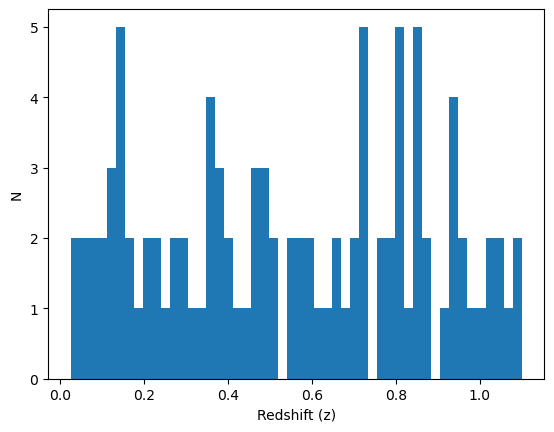

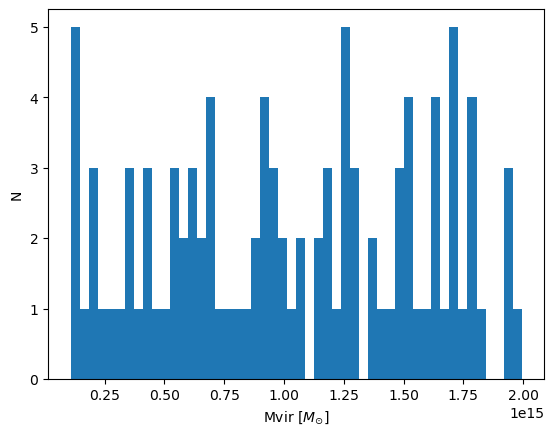

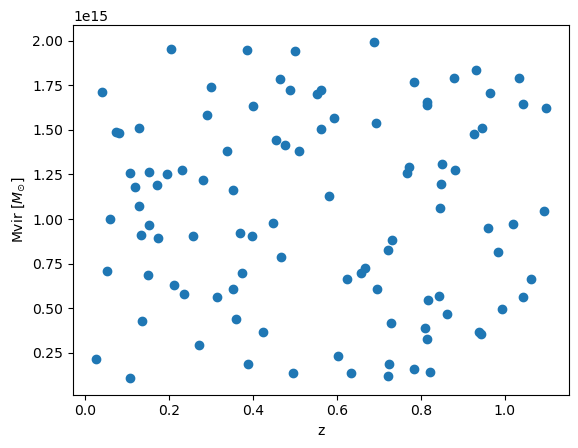

In [4]:
#Generate a new flat z, Mvir distribution and save to file: 
nsources=100 #Number of halos to generate
zdist,mdist=dm_halo_dist.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, Mvir distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'Mvir [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'Mvir [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

#Save this array to a h5 file
data = h5py.File('massdist.h5', 'w')
data.create_dataset('Redshift', data=zdist)
data.create_dataset('Mass', data=mdist)
data.create_dataset('id', data=idlist)
data.close()

Now we read our h5 file to access the simulated data. We save the redshift distribution to the variable `zdist`, mass distribution to `mdist` and the list of ids corresponding to each simulated galaxy cluster to `idlist`.

In [5]:
data = h5py.File('massdist.h5', 'r')
zdist = data['Redshift'][:]
mdist = data['Mass'][:]
idlist = data['id'][:]
data.close()

## Generating characteristics of galaxy clusters

The following code walks through how to utilize methods in `simsz` in order to generate characteristics of galaxy clusters.

The following values are example values for the purpose of the tutorial. we create an array of 10000 radii, from 0.01 to 10, initially in units of arcmin. We then convert the radii to Mpc. Next we initialize example redshift and M200 values. We then get R200 and c200 values from our M200 value.

In [6]:
r=np.linspace(0.01,10,10000) #arcmin
r=utils.arcmin_to_Mpc(r,0.5,d["cosmo"])
#make line for r in Mpc

In [7]:
z=0.48
M200=194038855760143.47 #solar masses

In [8]:
(M200,R200,c200)=make_sz_cluster.get_r200_and_c200(d["cosmo"],d["sigma8"],d["ns"],M200,z) #Use M200 to get R200 and concentration from Colossus

### Thermal Pressure Profile Generation

This section will walk through how to generate thermal pressure profiles for galaxy clusters. For this section we use equations from __[Battaglia 2012](https://arxiv.org/pdf/1109.3711.pdf)__ Section 4 (The Thermal Pressure Profile).

`P200` represents the normalized thermal pressure profile for a cluster of galaxies. 

In [9]:
P200 = make_sz_cluster.P200_Battaglia2012(d["cosmo"],z,M200,R200) #P200 from Battaglia et al. 2012

Here we generate fit parameters for a restricted version of a NFW profile. The input weights are chosen to be the inverse variances of fit parameter values from the individual pressure fits for each cluster within the bin.
- `P0`: amplitude
- `xc`: core-scale
- `beta`: power law index for the asymptotic fall off of the profile.

`Pth`, generated in the next block of code, is the restricted version of the NFW profile. We scale `Pth` by $ (r/R200)^3 $, like in Battaglia 2012 in order to replicate their pressure profile plots.

In [10]:
P0=make_sz_cluster._P0_Battaglia2012(M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc=make_sz_cluster._xc_Battaglia2012(M200,z)
beta=make_sz_cluster._beta_Battaglia2012(M200,z)

In [11]:
Pth=make_sz_cluster.Pth_Battaglia2012(r,R200,-0.3,1.0,beta,xc,P0) #Output Battaglia 2012 pressure profile

In [12]:
Pth_rescaled=(Pth)*(r/R200)**3.

Here, we graph the rescaled `Pth` on a log-log plot against $(r/R200)$. 

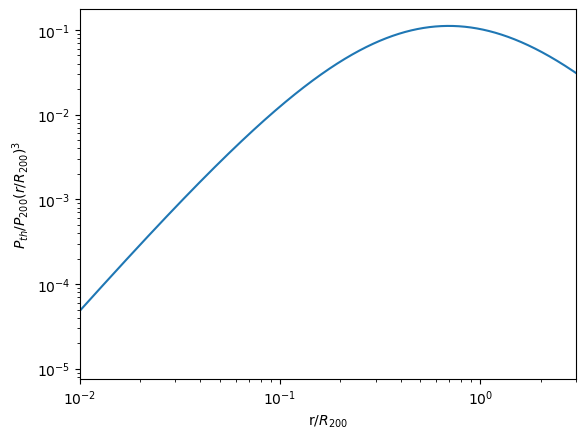

In [13]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.xlim(.010,3)
plt.show()

### Compton-y Profile Generation

Next, utilizing our pressure profile `Pth`, we find the Compton-y parameter (`y`) by utilizing the line of sight integral:

$$
  Y_\Delta = \frac{\sigma_T}{m_e c^2} \int_0^{R_{200}} P_e(r)4\pi r^2 \, dr$$


In [14]:
y = make_sz_cluster.epp_to_y(make_sz_cluster.Pth_Battaglia2012, r, R200_mpc=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200_kevcm3=P200)

In [15]:
y[0] #print central y value

2.2732088718286127e-05

Next, we find the corresponding temperatures from the central y value `y[0]`. We do this by utilizing the function `f_sz` which uses the equation:  $$ \frac{\partial T_{tsz} (\theta)}{T_{CMB}} = f_{sz}  y(\theta)$$ This equation is from __[Vavagiakis 2021](https://arxiv.org/pdf/2101.08373.pdf)__. where $y(\theta)$ is the Compton parameter at a projected angle $\theta$ from the cluster center.

In [16]:
fSZ=simtools.f_sz(150,d["cosmo"].Tcmb0) #get f_SZ for observation frequency of 30 GHz
dT=d["cosmo"].Tcmb0*y[0]*fSZ #get dT from y0 using f_SZ
dT=dT.to(u.uK) #Convert to uK
print(dT)

-59.03219236992315 uK


This is the generated 1D Compton-y profile, which plots our Compton-y profile `y` against the radius in Mpc.

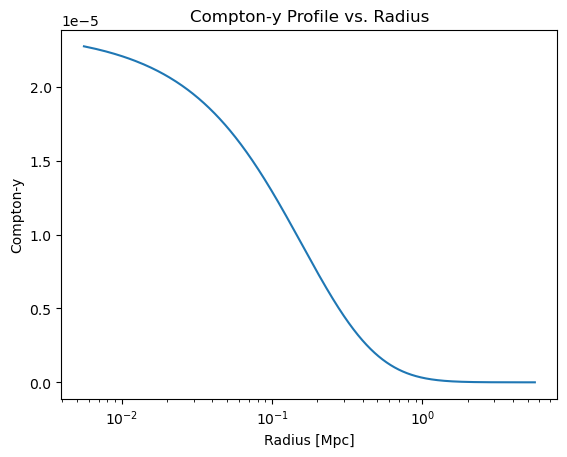

In [17]:
plt.plot(r, y)
plt.xlabel('Radius [Mpc]')
plt.ylabel('Compton-y')
plt.xscale('log')
plt.title('Compton-y Profile vs. Radius')
plt.show()

## Profile Visualization

The end goal of this section of our tutorial is to generate a convolved CMB map + SZ cluster with noise.

First, we utilize our Compton-y profile `y` to make 2D submap. In order to do this, utilize the `make_y_submap` function. We check that the 1D and 2D Compton-y maps agree with each other - the maximum value is at the center.

max:  1.9037641339685984e-10


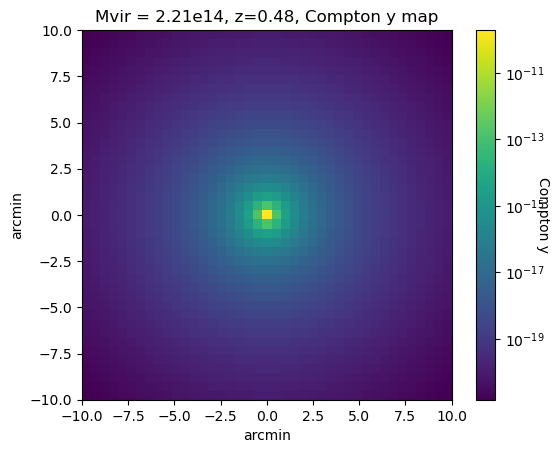

In [18]:
width = 10
y_map = make_sz_cluster._make_y_submap(make_sz_cluster.Pth_Battaglia2012, z, d["cosmo"], d["image_size_arcmin"], d["image_size_arcmin"], R200_mpc=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200_kevcm3=P200)
visualization.plot_graphs(y_map,'Mvir = 2.21e14, z=0.48, Compton y map','arcmin','arcmin','Compton y',logNorm=True)
print('max: ', y_map.max())

Next, we plot the temperature map, using the $f_{sz}$ equation again: $$ \frac{\partial T_{tsz} (\theta)}{T_{CMB}} = f_{sz}  y(\theta)$$

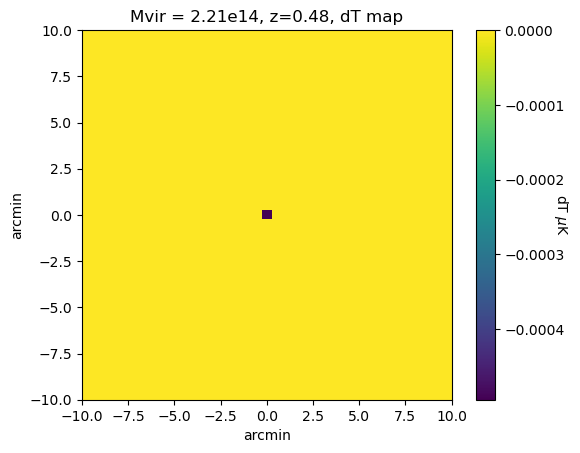

In [19]:
dT_map = (y_map * d["cosmo"].Tcmb0 * fSZ).to(u.uK).value
visualization.plot_graphs(dT_map,'Mvir = 2.21e14, z=0.48, dT map','arcmin','arcmin','dT $\mu$K',extend=True)

### CMB map generation

This is an example of what a generated CMB map will look like. We use the function `get_cls` in the `simtools` file to generate a power spectrum, which we then use to create the CMB map using `make_cmb_map`. This is just an example CMB map and not the one that we will be using for the graph generation in cells below. 

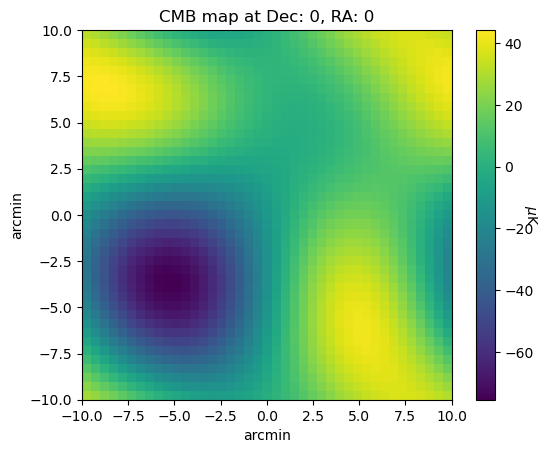

In [20]:
ps = simtools.get_cls(ns=d["ns"], cosmo=d["cosmo"])
cmb_map = simtools.make_cmb_map(shape=y_map.shape, pix_size_arcmin=d["pix_size_arcmin"], ps=ps)*u.uK
visualization.plot_graphs(cmb_map.value,'CMB map at Dec: 0, RA: 0','arcmin','arcmin','$\mu$K')
# This is in units of positive uK

### Creating a signal map

This is an example of what a generated signal map will look like. 

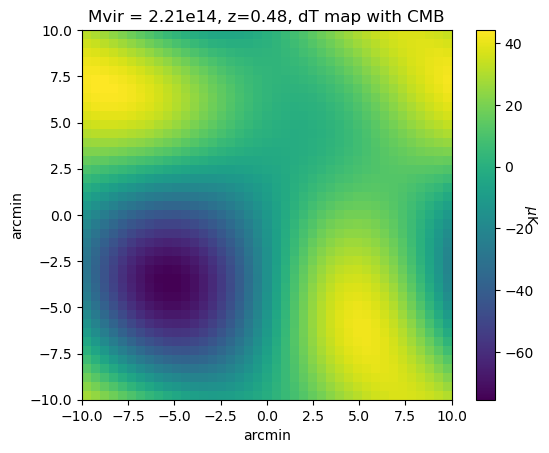

In [21]:
signal_map = dT_map + cmb_map.value # (fSZ * y + CMB) 
visualization.plot_graphs(signal_map,'Mvir = 2.21e14, z=0.48, dT map with CMB','arcmin','arcmin','$\mu$K')

### Beam Convolution

This what an example CMB map post-convolution will look like. Here we use the method `add_cmb_map_and_convolve` in `simtools`, which creates a CMB map, adds our cluster, convolves with a beam, and then eliminates edge effects.

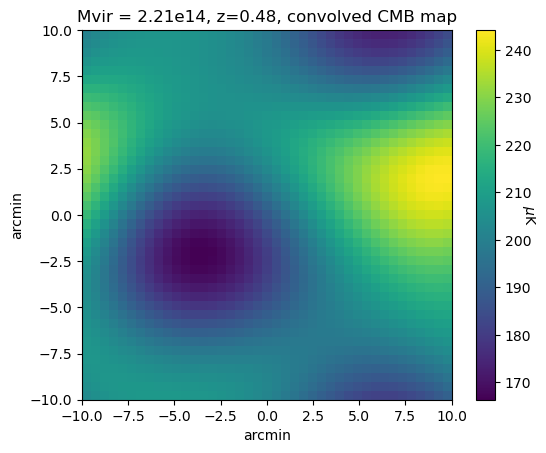

In [22]:
beam_size_fwhp = 1.25
conv_map, _ = simtools.add_cmb_map_and_convolve(dT_map, ps, d["pix_size_arcmin"], d["beam_size_arcmin"])
visualization.plot_graphs(conv_map,'Mvir = 2.21e14, z=0.48, convolved CMB map','arcmin','arcmin','$\mu$K')

### Adding Noise

Next, we add our generated noise map to the convolved CMB map using the `generate_noise_map` function in `noise`.

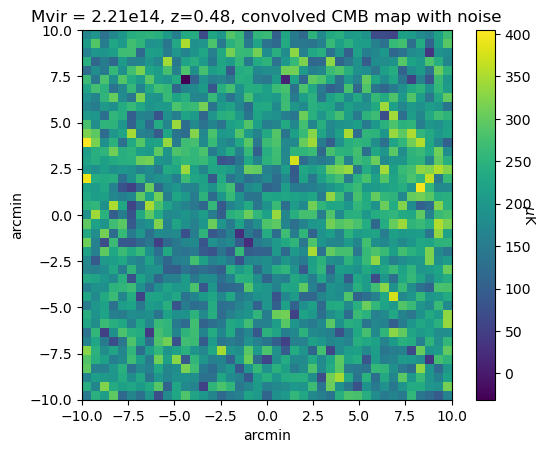

In [23]:
noise_map=noise.generate_noise_map(d["image_size_arcmin"], d["noise_level"], d["pix_size_arcmin"])
total_map=conv_map - noise_map
visualization.plot_graphs(total_map,'Mvir = 2.21e14, z=0.48, convolved CMB map with noise','arcmin','arcmin','$\mu$K',extend=True)

### Aperture Photometry

We can use the function `get_tSZ_signal_aperture_photometry` from `filters` to find the tSZ signal of our cluster.

Average in inner radius: 227.18238196049774
Average in outer radius: 188.4686374477088
tSZ signal: 38.713744512788935


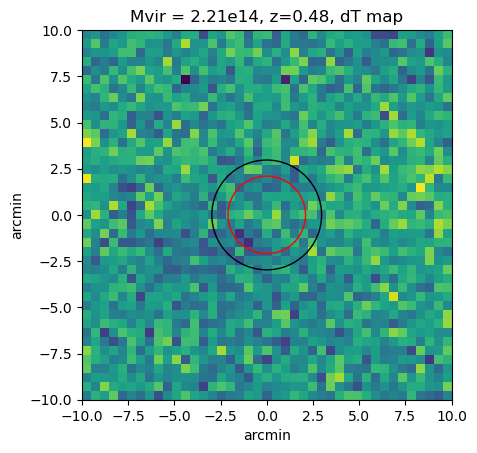

In [28]:
disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(total_map, 2.1)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(total_map.shape) / 2
center = center - center[0]
fig, ax = plt.subplots()
ax.imshow(total_map, extent=[-width,width,-width,width])
disk_circle = plt.Circle(center, 2.1, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, 2.1 * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.show()


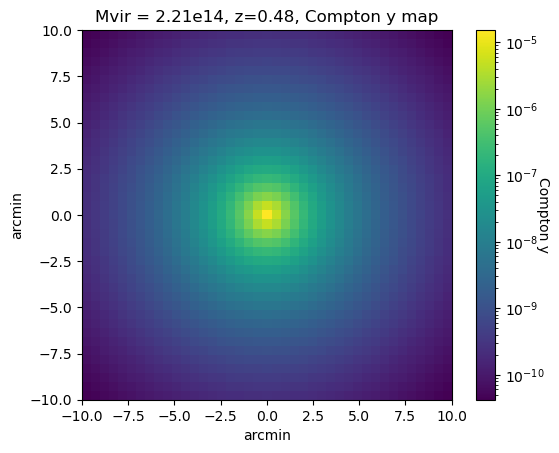

In [29]:
#This is the new function that just generates a submap without having to manually calculate params
y_map = make_sz_cluster.generate_y_submap(z, M200, R200, d["cosmo"], 41, 0.5)
visualization.plot_graphs(y_map,'Mvir = 2.21e14, z=0.48, Compton y map','arcmin','arcmin','Compton y',logNorm=True, extend=True)

## Storing Sims

This is an example block of code for storing sims. It saves the sim

In [24]:
sim_id = 1
# Data to be stored:
data = {
'temperature_submap': dT_map,
'noise_submap' : np.zeros((10,10)),
'cmb_submap' : cmb_map,
'y_central' : y_map[width][width],
'M200': M200,
'redshift_z': z,
'concentration': c200,
'ID': sim_id,
}
with h5py.File('sz_sim_data.h5', 'a') as f:
    utils.save_sim_to_h5(f, f"sim_{sim_id}", data, overwrite=True)

In [30]:
#This simulates submaps for a distribution, and saves the data to a h5 file, and params to a yaml file
clusters = make_sz_cluster.simulate_submap(mdist, zdist)

In [ ]:
simulated_map = clusters[0]['final_map'] - clusters[0]['noise_map']
visualization.plot_graphs(simulated_map,' ','arcmin','arcmin','$\mu$K')
clusters[0]['M200']/1e14